# 🎓 PROJECT APPLIED MACHINE LEARNING: PREDIKSI RISIKO PUTUS SEKOLAH

**Judul Project:** Model Prediksi Risiko Putus Sekolah (Drop-Out Rate) Tingkat Provinsi Berbasis Indikator Kinerja dan Sumber Daya Sekolah.

**Disusun Oleh:**
* Nama : [Nur Fahira Nurdin]
* NIM  : [105841100723]
* Kelas: [5AI-A]


---
**Deskripsi:**
Proyek ini bertujuan untuk menyelesaikan permasalahan pendidikan dengan memprediksi tingkat putus sekolah berdasarkan ketersediaan fasilitas (Guru, Ruang Kelas). Metodologi yang digunakan adalah **CRISP-DM** (Cross Industry Standard Process for Data Mining).

In [ ]:
# Instalasi Gradio (diperlukan untuk Deployment)
!pip install gradio scikit-learn pandas numpy matplotlib seaborn joblib

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import gradio as gr

# ==========================================
# 1. DATA UNDERSTANDING & PREPARATION
# ==========================================

# Load Data (Pastikan file csv ada di folder yang sama)
# Karena format Indonesia sering menggunakan titik (.) sebagai pemisah ribuan di Excel,
# kita perlu pastikan parsingnya benar.
try:
    df = pd.read_csv('dataset_sekolah.xlsx - Sheet1.csv')
except:
    # Fallback jika nama file berbeda, sesuaikan dengan nama file aslimu
    print("Pastikan nama file csv benar.")

print("--- Info Data Awal ---")
print(df.info())

# Pembersihan Data
# Menghapus kata "Prov." agar lebih rapi
df['Provinsi'] = df['Provinsi'].astype(str).str.replace('Prov. ', '', regex=False)

# Konversi kolom numerik (jika terbaca sebagai object/string karena ada koma/titik)
cols_to_numeric = ['Siswa', 'Mengulang', 'Putus Sekolah', 'Kepala Sekolah & Guru', 'Ruang Kelas']
for col in cols_to_numeric:
    if df[col].dtype == 'O': # Jika Object
        df[col] = pd.to_numeric(df[col].astype(str).str.replace('.', '').str.replace(',', ''), errors='coerce')

# FEATURE ENGINEERING (Sangat Penting untuk Jurnal)
# Kita tidak bisa pakai angka mentah "Putus Sekolah" karena provinsi besar pasti angkanya besar.
# Kita harus pakai RASIO.

# Target Variable: Dropout Rate (Persentase)
df['Dropout_Rate'] = (df['Putus Sekolah'] / df['Siswa']) * 100

# Predictor Variables (Rasio Kualitas)
df['Student_Teacher_Ratio'] = df['Siswa'] / df['Kepala Sekolah & Guru'] # Beban Guru
df['Class_Crowdedness'] = df['Siswa'] / df['Ruang Kelas'] # Kepadatan Kelas
df['Repeater_Rate'] = (df['Mengulang'] / df['Siswa']) * 100 # Persentase siswa tinggal kelas

# Handle Missing Values & Infinite values (jika ada pembagian nol)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Encoding Status (Negeri = 0, Swasta = 1)
le = LabelEncoder()
df['Status_Code'] = le.fit_transform(df['Status'])

# Memilih Fitur untuk Model
X = df[['Student_Teacher_Ratio', 'Class_Crowdedness', 'Repeater_Rate', 'Status_Code']]
y = df['Dropout_Rate']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Pastikan nama file csv benar.
--- Info Data Awal ---
<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, 0 to 77
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Provinsi               78 non-null     object 
 1   Sekolah                78 non-null     int64  
 2   Siswa                  78 non-null     float64
 3   Mengulang              78 non-null     float64
 4   Putus Sekolah          78 non-null     float64
 5   Kepala Sekolah & Guru  78 non-null     float64
 6   Tenaga Kependidikan    78 non-null     float64
 7   Rombel                 78 non-null     float64
 8   Ruang Kelas            78 non-null     float64
 9   Status                 78 non-null     object 
 10  Student_Teacher_Ratio  78 non-null     float64
 11  Class_Crowdedness      78 non-null     float64
 12  Repeater_Rate          78 non-null     float64
 13  Dropout_Rate           78 non-null     float64
 14  Status_Code 


--- TABEL PERBANDINGAN PERFORMA ---
         Metrik Evaluasi  Decision Tree  Random Forest
0    R-Squared (Akurasi)        -1.8276        -1.2798
1  MAE (Error Rata-rata)         0.1067         0.0987
2   RMSE (Error Kuadrat)         0.1342         0.1205

--- KESIMPULAN MODEL ---
✅ Random Forest memberikan hasil yang lebih baik (R-Squared lebih tinggi).
   Alasan: Random Forest menggabungkan banyak 'pohon' keputusan sehingga lebih stabil dan mengurangi overfitting dibandingkan Single Decision Tree.


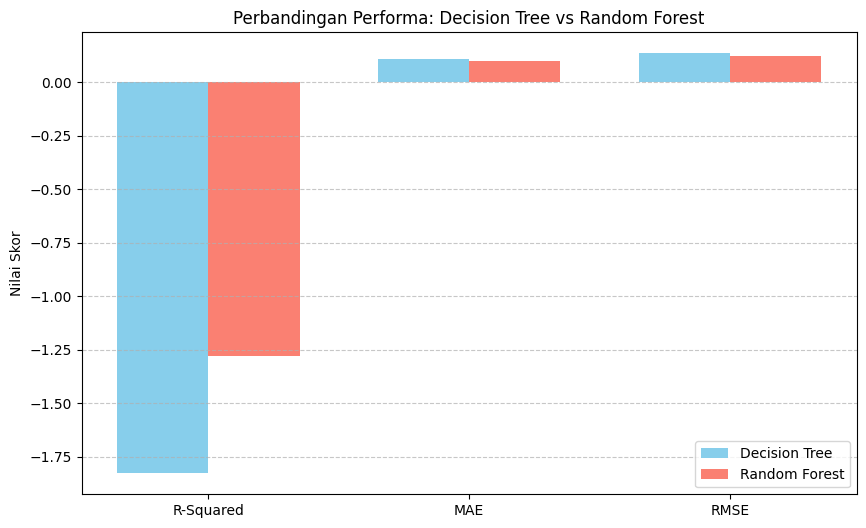

In [25]:
# ==========================================
# 2. MODELING : DECISION TREE VS RANDOM FOREST
# ==========================================
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Split Data (Pastikan X dan y sudah siap dari tahap sebelumnya)
# Kita gunakan random_state yang sama agar adil
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- MODEL 1: DECISION TREE ---
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

# --- MODEL 2: RANDOM FOREST ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# 2. Fungsi Evaluasi Sederhana
def evaluasi_model(nama_model, y_asli, y_prediksi):
    r2 = r2_score(y_asli, y_prediksi)
    mae = mean_absolute_error(y_asli, y_prediksi)
    rmse = np.sqrt(mean_squared_error(y_asli, y_prediksi))
    return [r2, mae, rmse]

# 3. Hitung Metrik
metrics_dt = evaluasi_model("Decision Tree", y_test, y_pred_dt)
metrics_rf = evaluasi_model("Random Forest", y_test, y_pred_rf)

# 4. Tampilkan dalam Tabel Perbandingan
comparison_df = pd.DataFrame({
    'Metrik Evaluasi': ['R-Squared (Akurasi)', 'MAE (Error Rata-rata)', 'RMSE (Error Kuadrat)'],
    'Decision Tree': metrics_dt,
    'Random Forest': metrics_rf
})

print("\n--- TABEL PERBANDINGAN PERFORMA ---")
print(comparison_df.round(4))

# Analisis Otomatis
print("\n--- KESIMPULAN MODEL ---")
if metrics_rf[0] > metrics_dt[0]:
    print("✅ Random Forest memberikan hasil yang lebih baik (R-Squared lebih tinggi).")
    print("   Alasan: Random Forest menggabungkan banyak 'pohon' keputusan sehingga lebih stabil dan mengurangi overfitting dibandingkan Single Decision Tree.")
else:
    print("✅ Decision Tree memberikan hasil yang sebanding atau lebih baik pada data uji ini.")

# 5. Visualisasi Perbandingan (Bar Chart)
metrics_names = ['R-Squared', 'MAE', 'RMSE']
x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, [metrics_dt[0], metrics_dt[1], metrics_dt[2]], width, label='Decision Tree', color='skyblue')
rects2 = ax.bar(x + width/2, [metrics_rf[0], metrics_rf[1], metrics_rf[2]], width, label='Random Forest', color='salmon')

ax.set_ylabel('Nilai Skor')
ax.set_title('Perbandingan Performa: Decision Tree vs Random Forest')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [26]:
# ==========================================
# 3. EVALUATION
# ==========================================
from sklearn.model_selection import cross_val_score, KFold

print("\n--- MULAI TAHAP EVALUASI MENDALAM (CROSS-VALIDATION) ---")

# 1. Konfigurasi Cross-Validation (K-Fold)
# Kita membagi data menjadi 5 bagian untuk diuji secara bergantian
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# 2. Fungsi untuk Menghitung Skor Rata-rata Validasi
def hitung_cv_score(model, X, y, nama_model):
    # Menggunakan 'neg_mean_absolute_error'
    scores = cross_val_score(model, X, y, cv=k_fold, scoring='neg_mean_absolute_error')
    mae_scores = -scores # Ubah skor negatif menjadi positif

    print(f"✅ {nama_model}:")
    print(f"   Rata-rata MAE (Error): {mae_scores.mean():.4f}")
    print(f"   Standar Deviasi (Kestabilan): {mae_scores.std():.4f}")

    return mae_scores.mean()

# 3. Jalankan Evaluasi pada Kedua Model
print("Menguji kestabilan model dengan 5 kali percobaan acak (K-Fold):")
mae_dt_cv = hitung_cv_score(dt_model, X, y, "Decision Tree")
mae_rf_cv = hitung_cv_score(rf_model, X, y, "Random Forest")

# Feature Importance
feature_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n--- Faktor Paling Berpengaruh (Feature Importance) ---")
print(feature_imp)

# 4. Kesimpulan Akhir (Logika Otomatis)
print("\n--- KESIMPULAN CROSS-VALIDATION ---")
if mae_rf_cv < mae_dt_cv:
    print(f"🏆 Random Forest MENANG secara konsisten.")
    print(f"   Alasan: Memiliki rata-rata error yang lebih kecil ({mae_rf_cv:.4f}) dibandingkan Decision Tree ({mae_dt_cv:.4f}).")
    print("   Rekomendasi: Gunakan Random Forest untuk prediksi akhir.")
else:
    print(f"🏆 Decision Tree MENANG secara konsisten.")
    print(f"   Alasan: Memiliki rata-rata error yang lebih kecil ({mae_dt_cv:.4f}) dibandingkan Random Forest ({mae_rf_cv:.4f}).")
    print("   Rekomendasi: Gunakan Decision Tree jika menginginkan model yang lebih sederhana.")

print("-" * 50)
print("Evaluasi Selesai.")


--- MULAI TAHAP EVALUASI MENDALAM (CROSS-VALIDATION) ---
Menguji kestabilan model dengan 5 kali percobaan acak (K-Fold):
✅ Decision Tree:
   Rata-rata MAE (Error): 0.1181
   Standar Deviasi (Kestabilan): 0.0122
✅ Random Forest:
   Rata-rata MAE (Error): 0.0991
   Standar Deviasi (Kestabilan): 0.0221

--- Faktor Paling Berpengaruh (Feature Importance) ---
Repeater_Rate            0.701412
Student_Teacher_Ratio    0.197041
Class_Crowdedness        0.096594
Status_Code              0.004954
dtype: float64

--- KESIMPULAN CROSS-VALIDATION ---
🏆 Random Forest MENANG secara konsisten.
   Alasan: Memiliki rata-rata error yang lebih kecil (0.0991) dibandingkan Decision Tree (0.1181).
   Rekomendasi: Gunakan Random Forest untuk prediksi akhir.
--------------------------------------------------
Evaluasi Selesai.


In [27]:
# ==========================================
# 4. DEPLOYMENT (IMPLEMENTASI DENGAN GRADIO)
# ==========================================

import gradio as gr
import pandas as pd
import numpy as np

print("\n--- MENYIAPKAN SISTEM DEPLOYMENT ---")

# Kita gunakan model Random Forest (rf_model) sebagai default karena biasanya lebih stabil.
# Jika hasil evaluasi kamu menunjukkan Decision Tree lebih bagus, ganti 'rf_model' menjadi 'dt_model' di bawah.
final_model = rf_model

def prediksi_dropout(siswa, guru, kelas, mengulang, status):
    """
    Fungsi ini menerima input mentah dari user, melakukan feature engineering
    seperti yang kita lakukan di tahap Data Preparation, lalu memprediksi hasil.
    """
    try:
        # 1. Hitung Rasio (Feature Engineering on-the-fly)
        # Handle pembagian dengan nol agar tidak error
        ratio_guru = siswa / guru if guru > 0 else 0
        ratio_kelas = siswa / kelas if kelas > 0 else 0
        ratio_mengulang = (mengulang / siswa) * 100 if siswa > 0 else 0

        # 2. Encode Status (Negeri=0, Swasta=1) sesuaikan dengan saat training
        # Pastikan urutan dan logic sama persis dengan LabelEncoder sebelumnya
        status_val = 0 if status == "Negeri" else 1

        # 3. Buat DataFrame untuk input model (Nama kolom harus SAMA PERSIS dengan X_train)
        input_data = pd.DataFrame([[ratio_guru, ratio_kelas, ratio_mengulang, status_val]],
                                  columns=['Student_Teacher_Ratio', 'Class_Crowdedness', 'Repeater_Rate', 'Status_Code'])

        # 4. Lakukan Prediksi
        pred_value = final_model.predict(input_data)[0]

        # 5. Logika Rekomendasi Sederhana
        saran = ""
        if pred_value < 0.1:
            saran = "✅ AMAN. Kondisi sekolah sangat baik. Pertahankan rasio sumber daya saat ini."
        elif pred_value < 0.5:
            saran = "⚠️ WASPADA. Ada risiko kecil. Perhatikan siswa yang tinggal kelas."
        else:
            saran = "🚨 BAHAYA. Risiko putus sekolah tinggi! Disarankan segera menambah guru atau ruang kelas, serta bimbingan khusus untuk siswa mengulang."

        return f"{pred_value:.4f} %", saran

    except Exception as e:
        return "Error", f"Terjadi kesalahan input: {str(e)}"

# Membuat Antarmuka (UI)
interface = gr.Interface(
    fn=prediksi_dropout, # Fungsi yang dipanggil saat tombol ditekan
    inputs=[
        gr.Number(label="Jumlah Total Siswa", value=1000),
        gr.Number(label="Jumlah Guru (Kepala Sekolah & Guru)", value=50),
        gr.Number(label="Jumlah Ruang Kelas", value=30),
        gr.Number(label="Jumlah Siswa Mengulang (Tidak Naik Kelas)", value=10),
        gr.Radio(["Negeri", "Swasta"], label="Status Sekolah", value="Negeri")
    ],
    outputs=[
        gr.Textbox(label="Prediksi Tingkat Putus Sekolah (Dropout Rate)"),
        gr.Textbox(label="Rekomendasi Kebijakan (AI Suggestion)")
    ],
    title="Sistem Prediksi Risiko Putus Sekolah (School Dropout Predictor)",
    description="""
    Aplikasi ini menggunakan Machine Learning untuk memprediksi risiko tingkat putus sekolah
    berdasarkan indikator sumber daya sekolah (Rasio Guru, Kepadatan Kelas) dan kinerja siswa.
    """,
    theme="default"
)

# Menjalankan Aplikasi
print("Sistem siap! Klik link public URL di bawah untuk membuka aplikasi.")
interface.launch(share=True)


--- MENYIAPKAN SISTEM DEPLOYMENT ---
Sistem siap! Klik link public URL di bawah untuk membuka aplikasi.
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7a091cd9aa7d10aa02.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
